## Implementing OVA logistic regression for the CIFAR-10 dataset
In this assignment, you will implement a one-vs-all logistic regression classifier, and apply it to a version of the CIFAR-10 object recognition dataset. 

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython

%load_ext autoreload
%autoreload 2

## Load the CIFAR-10 dataset
Open up a terminal window and navigate to the **datasets** folder inside the  **hw3** folder. Run the
**get\_datasets.sh**  script. On my Mac, I just type in **./get\_datasets.sh** at the shell prompt.
A new folder called **cifar\_10\_batches\_py** will be created and it will contain $50000$ labeled
images for training and $10000$ labeled images for testing. The function further partitions the $50000$ training 
images into a train set and a validation set for selection of hyperparameters. We have provided a function to
read this data in **utils.py**. Each image is a $32 \times 32$ array of RGB triples. It is preprocessed by
subtracting the mean image from all images. We flatten each image into a 1-dimensional array of size
3072 (i.e., $32\times 32 \times 3$). Then a 1 is appended to the front of that vector to handle 
the intercept term.  So the training set is a numpy matrix of size $49000\times 3073$, 
the validation set is a matrix of size $1000\times 3073$ and the set-aside test set 
is of size $10000\times 3073$.

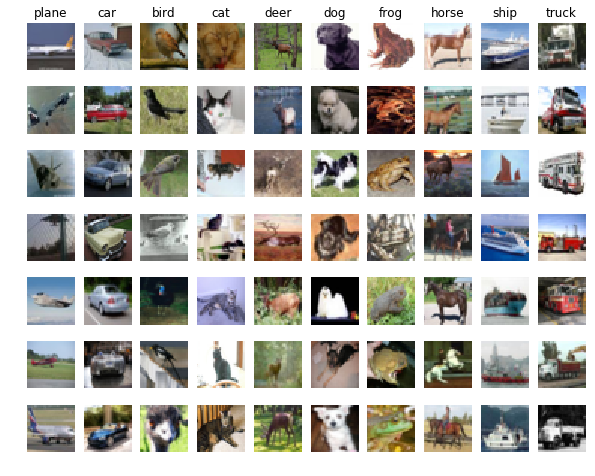

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (10000, 3072)
Training data shape with bias term:  (49000, 3073)
Validation data shape with bias term:  (1000, 3073)
Test data shape with bias term:  (10000, 3073)


In [2]:
import utils

# Get the CIFAR-10 data broken up into train, validation and test sets

X_train, y_train, X_val, y_val, X_test, y_test = utils.get_CIFAR10_data()

## Implementing a one_vs_all classifier for CIFAR-10
In this part of the exercise, you will implement one-vs-all classifier by training multiple regularized binary logistic regression classifiers, one for each of the ten classes in our dataset. You should now complete the code in **one\_vs\_all.py** to train one classifier for each class. In particular, your code should return all the classifier parameters in a matrix $\Theta \in \Re^{(d+1) \times K}$,  where each column of $\Theta$ corresponds to the learned logistic regression parameters for a class. You can do this with a for-loop from $0$ to $K − 1$, training each classifier independently.
When training the classifier for class $k \in \{0, . . . , K − 1\}$, you should build a new label for each example $x$ as follows: label $x$ as 1 if $x$ belomgs to class $k$ and zero otherwise. You can use sklearn's logistic regression function to learn each classifier. 

In [3]:
from one_vs_all import one_vs_allLogisticRegressor

ova_logreg = one_vs_allLogisticRegressor(np.arange(10))

# train 
reg = 1.0
ova_logreg.train(X_train,y_train,reg)

# predict on test set
y_test_pred = ova_logreg.predict(X_test)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_correct = {key:0 for key in classes}
class_total = {key:0 for key in classes}
for i in xrange(len(y_test)):
    class_total[classes[y_test[i]]] += 1
    if y_test[i]==y_test_pred[i]:
        class_correct[classes[y_test[i]]] += 1
for key in class_correct:
    class_correct[key] = class_correct[key] / float(class_total[key])
print class_correct


from sklearn.metrics import confusion_matrix
test_accuracy = np.mean(y_test == y_test_pred)
print 'one_vs_all on raw pixels final test set accuracy: %f' % (test_accuracy, )
print confusion_matrix(y_test,y_test_pred)

(3073, 10)
{'horse': 0.406, 'car': 0.463, 'deer': 0.234, 'dog': 0.272, 'frog': 0.457, 'cat': 0.161, 'plane': 0.465, 'truck': 0.42, 'ship': 0.541, 'bird': 0.194}
one_vs_all on raw pixels final test set accuracy: 0.361300
[[465  59  22  24  19  35  26  60 200  90]
 [ 67 463  18  34  23  31  44  51  96 173]
 [123  64 194  77  96  89 151  88  70  48]
 [ 67  86  78 161  48 193 171  51  62  83]
 [ 65  38 102  64 234  90 194 129  36  48]
 [ 47  63  81 127  81 272 114  89  71  55]
 [ 31  53  67 102  86  78 457  51  29  46]
 [ 53  62  51  46  69  85  66 406  47 115]
 [149  78   8  25   9  34  22  19 541 115]
 [ 59 208  14  22  23  29  60  56 109 420]]


## Visualizing the learned one-vs-all classifier

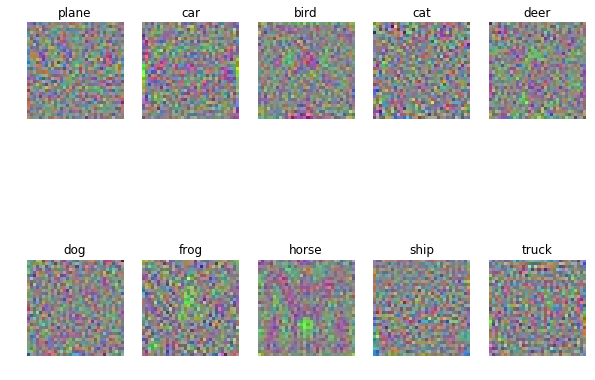

In [4]:
# Visualize the learned weights for each class

theta = ova_logreg.theta[1:,:].T # strip out the bias term
theta = theta.reshape(10, 32, 32, 3)

theta_min, theta_max = np.min(theta), np.max(theta)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  thetaimg = 255.0 * (theta[i].squeeze() - theta_min) / (theta_max - theta_min)
  plt.imshow(thetaimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

plt.show()

## Comparing your functions with sklearn's

In [5]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model

# train on train set with reg
sklearn_ova = OneVsRestClassifier(linear_model.LogisticRegression(C=1.0/reg,penalty='l2',
                                                                  fit_intercept=False,solver='lbfgs'))
sklearn_ova.fit(X_train, y_train)     

# predict on test set
y_test_pred_sk = sklearn_ova.predict(X_test)

sk_test_accuracy = np.mean(y_test == y_test_pred_sk)
print 'one_vs_all on raw pixels final test set accuracy (sklearn): %f' % (sk_test_accuracy, )
print confusion_matrix(y_test,y_test_pred_sk)                             

one_vs_all on raw pixels final test set accuracy (sklearn): 0.361300
[[465  59  22  24  19  35  26  60 200  90]
 [ 67 463  18  34  23  31  44  51  96 173]
 [123  64 194  77  96  89 151  88  70  48]
 [ 67  86  78 161  48 193 171  51  62  83]
 [ 65  38 102  64 234  90 194 129  36  48]
 [ 47  63  81 127  81 272 114  89  71  55]
 [ 31  53  67 102  86  78 457  51  29  46]
 [ 53  62  51  46  69  85  66 406  47 115]
 [149  78   8  25   9  34  22  19 541 115]
 [ 59 208  14  22  23  29  60  56 109 420]]


## Visualizing the sklearn OVA classifier

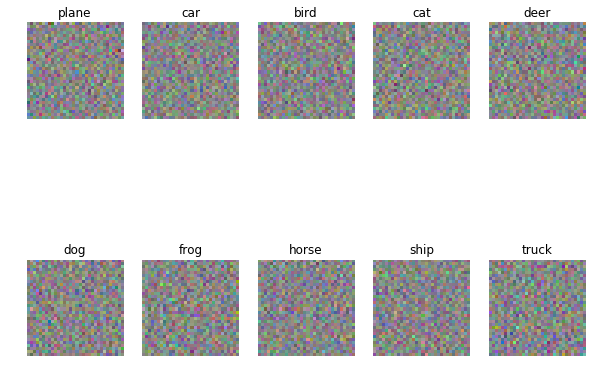

In [6]:
# Visualize the learned weights for each class

theta = sklearn_ova.coef_[:,1:].T # strip out the bias term
theta = theta.reshape(10, 32, 32, 3)

theta_min, theta_max = np.min(theta), np.max(theta)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  thetaimg = 255.0 * (theta[i].squeeze() - theta_min) / (theta_max - theta_min)
  plt.imshow(thetaimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

plt.show()